In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix
from scripts_tempHelix import generate_static_temporal_helix, generate_temporal_helix, multiple_exponential_temporal_helix,generate_temporal_helix2
from scripts_theoreticalHittingTime import create_transition_matrix

In [2]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
figsize = (15, 6)
k = 0.2
draw_self_loops = False

config = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_0'
}

config1 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_1'
}

config2 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_2'
}

config3 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_3'
}

# New graph every step

In [3]:
def estimate_hitting_time(reps, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for rep in range(1,reps+1):
        print(f'\nCalculatig hitting time for reps = {rep} ; n = {3+3*rep}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.from_numpy_array(generate_temporal_helix(rep,0))
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s == 0 or s == 1 or s % 5 == 0:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                graph = nx.from_numpy_array(generate_temporal_helix(rep,total_steps_this_simulation))
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def estimate_hitting_time2(reps, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for rep in range(1,reps+1):
        print(f'\nCalculatig hitting time for reps = {rep} ; n = {3+3*rep}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.from_numpy_array(generate_temporal_helix2(rep,0))
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s == 0 or s == 1 or s % 5 == 0:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                graph = nx.from_numpy_array(generate_temporal_helix2(rep,total_steps_this_simulation))
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def theoretical_hitting_time(P1,P2,P3, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P1.shape[0]  # Number of states
    
    P1_uu = P1[:target, :target]
    P2_uu = P2[:target, :target]
    P3_uu = P3[:target, :target]
    
    init_dist = np.zeros(n-1)
    init_dist[init] = 1
    
    target_dist = np.ones(n-1)
    
    I = np.eye(n-1)

    P_uu_inv = np.linalg.inv(I - np.matmul(P1_uu, 
                             np.matmul(P2_uu,P3_uu)))
    
    P_uu = np.matmul( np.matmul(P1_uu,P2_uu)+P1_uu+I, P_uu_inv).T
    
    # print_matrix(P_uu)
        
    hitting_time = np.dot(init_dist, np.dot(P_uu, target_dist))

    return hitting_time

def hitting_times_for_tempHelix_graphs(reps, init, target):
    hitting_times = []
    for rep in range(1,reps+1):
            G1 = nx.from_numpy_array(generate_temporal_helix(rep,0))
            G2 = nx.from_numpy_array(generate_temporal_helix(rep,1))
            G3 = nx.from_numpy_array(generate_temporal_helix(rep,2))
            P1 = create_transition_matrix(G1)
            P2= create_transition_matrix(G2)
            P3 = create_transition_matrix(G3)
            hitting_time = theoretical_hitting_time(P1,P2,P3, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

def hitting_times_for_tempHelix_graphs2(reps, init, target):
    hitting_times = []
    for rep in range(1,reps+1):
            G1 = nx.from_numpy_array(generate_temporal_helix2(rep,0))
            G2 = nx.from_numpy_array(generate_temporal_helix2(rep,1))
            G3 = nx.from_numpy_array(generate_temporal_helix2(rep,2))
            P1 = create_transition_matrix(G1)
            P2= create_transition_matrix(G2)
            P3 = create_transition_matrix(G3)
            hitting_time = theoretical_hitting_time(P1,P2,P3, init, target)
            hitting_times.append(hitting_time)
    return hitting_times


def fit_hitting_time(reps,epsilon,factor):
    cover_times = []
    k = 0
    for n in range(1,reps+1):
        k = n**epsilon
        cover_times.append(2**(factor*k))
    return cover_times
       
    return hitting_times

def fit_hitting_time_2(reps,factor):
    cover_times = []
    k = 0
    for n in range(1,reps+1):
        cover_times.append(2**(factor*n))
    return cover_times
       
    return hitting_times


# With autoloops

In [4]:
epsilon = 0.50

reps = 8
nrange2 = [3 + 3*rep for rep in range(1,reps)]
nrange3 = [3 + 3*rep for rep in range(1,reps+1)]
factor = 4.7

fromNode = 0
toNode = -1


samples = 20


hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeV2TemporalHelix_N{nrange2[0]}-{nrange2[-1]}_EPS{epsilon}_S{samples}.txt'

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    estimate_hitting_time_memory = [x for x in fit_hitting_time(reps,epsilon,factor)]
    print('File exists!')
else:
    print('File Doesnt Exist!')
    hitting_times = estimate_hitting_time(reps,fromNode,toNode, num_simulations=samples)
    write_list_to_file(hitting_times_file, hitting_times)
    estimate_hitting_time_memory = [x for x in fit_hitting_time(reps,epsilon,factor)]

File exists!


In [5]:
reps = 8

init = 0
target = -1

theoretical_hitting_times = hitting_times_for_tempHelix_graphs(reps, init, target)

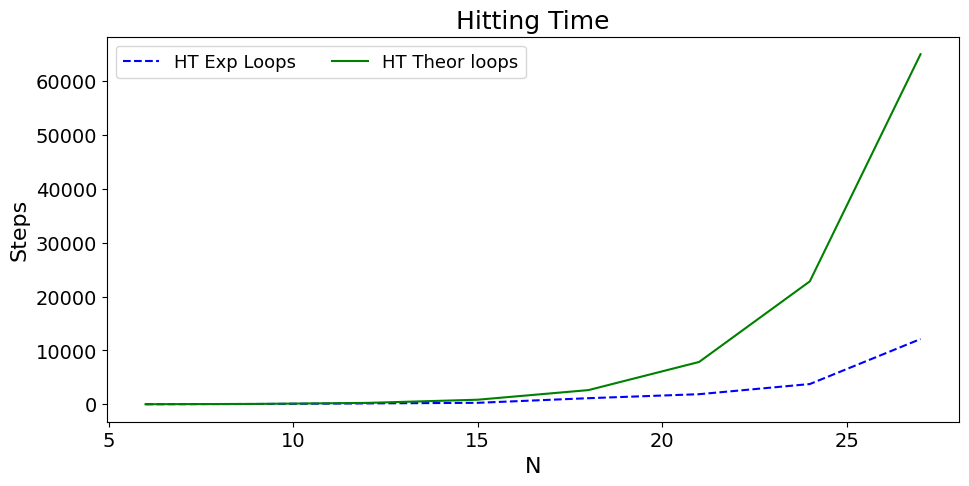

In [6]:
alphaLabelList = ['HT Exp Loops', 'HT Theor loops',]

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

y_value_matrix = [hitting_times,
                 theoretical_hitting_times]
plot_qwak(x_value_matrix = [list(nrange3)]*len(y_value_matrix) , y_value_matrix = y_value_matrix,**params)

# No autoloops

In [7]:
epsilon = 0.50

reps = 6
nrange2 = [3 + 3*rep for rep in range(1,reps)]
nrange3 = [3 + 3*rep for rep in range(1,reps+1)]
factor = 4.7
sum_range = [3 + 3*rep for rep in range(1,reps+1)]


fromNode = 0
toNode = -1


samples = 20


hitting_times_file = f'Datasets/HTDynTempHelix/hittingTimeV2TemporalHelix_noSelfLoops_N{nrange2[0]}-{nrange2[-1]}_EPS{epsilon}_S{samples}.txt'

# hitting_times2 = estimate_hitting_time2(reps,fromNode,toNode, num_simulations=samples)

if os.path.exists(hitting_times_file):
    hitting_times2 = load_list_from_file(hitting_times_file)
    estimate_hitting_time_memory2 = [x for x in fit_hitting_time(reps,epsilon,factor)]
    print('File exists!')
else:
    print('File Doesnt Exist!')
    hitting_times2 = estimate_hitting_time2(reps,fromNode,toNode, num_simulations=samples)
    write_list_to_file(hitting_times_file, hitting_times2)
    estimate_hitting_time_memory2 = [x for x in fit_hitting_time(reps,epsilon,factor)]

File exists!


In [11]:
reps = 6

init = 0
target = -1

theoretical_hitting_times2 = hitting_times_for_tempHelix_graphs2(reps, init, target)

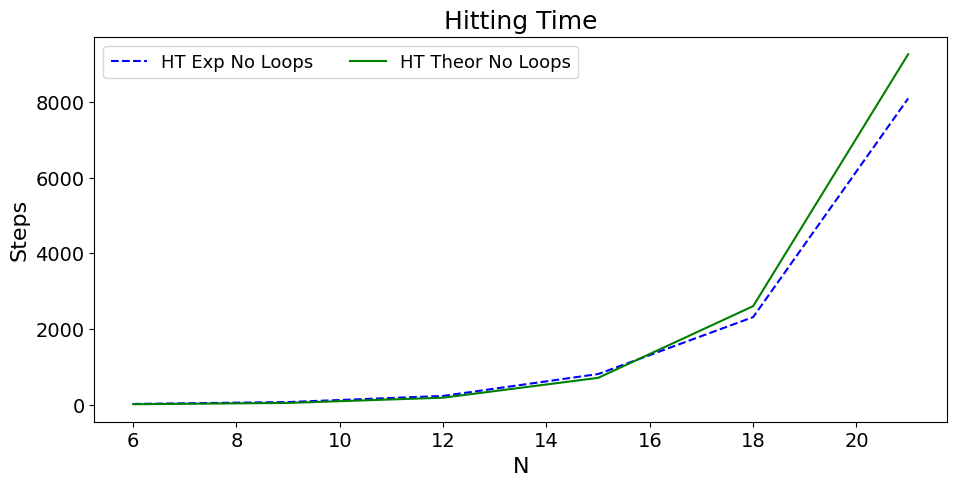

In [12]:
alphaLabelList = ['HT Exp No Loops', 'HT Theor No Loops','HT Theor Loops']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

y_value_matrix = [hitting_times2,
                 theoretical_hitting_times2,]
plot_qwak(x_value_matrix = [list(nrange3)]*len(y_value_matrix) , y_value_matrix = y_value_matrix,**params)